# Run Sentiment Analysis on Forum Data
This notebook loads the Youbemom special needs forum text and compares sentiment pre- and during the COVID-19 pandemic

## Data Sources
- youbemomTables.db (scraped with 1-Scrape_Forum.ipynb)

## Changes
- 2020-08-13: Set up data cleaning
- 2020-08-20: Added t-tests
- 2020-08-26: Added plots
- 2020-09-14: Added more plots
- 2020-09-15: Compared parent and child sentiment

## Database Structure
- threads
 - id: automatically assigned
 - url: url of top post
- posts
 - id: automatically assigned
 - family_id: thread->id
 - message_id: the unique id of the message from the html
 - parent_id: id of post this post is responding to, 0 if top post
 - date_recorded: date the data is fetched
 - date_created: date the data was created
 - title: title of the post
 - body: body of the post

## TODO
- Does python have a regression function for continuous dependent variables between 0 and 1 or will I have to use R/Stata for a fractional regression model?
- Set up functions for the plots so I can plug in the variable I want to see
- Does sentiment differ between parents and children in threads?
 - Is sentiment more negative after negative posts? More positive after positive posts?
- Is there a time-dependent function here?
 - Seasonality?
 - Does tweaking the time period cutoffs affect the significance?
- Frequency distribution of words

## Imports

In [1]:
import sqlite3
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.stats import ttest_ind, kde
from datetime import datetime
# from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer #, word_tokenize
from nltk.corpus import stopwords
import string
import re
from pathlib import Path
import matplotlib.pyplot as plt
import math
from statsmodels.formula.api  import ols

## Functions
For accessing the database

In [2]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by the db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as err:
        print(err)
    return conn

For formatting the data

In [3]:
def format_data(df):
    """ format the data frame from sql so dates are in
        datetime format and creates text column from
        title and body
    :param df: data frame
    :return df: formatted data frame
    """
    df['date_recorded'] = pd.to_datetime(df['date_recorded'])
    df['date_created'] = pd.to_datetime(df['date_created'])
    # text = title + body
    df['title'] = df['title'].replace('This post has been deleted\.', '', regex=True)
    df['text'] = df['title'] + " " + df['body']
    return df

In [4]:
def clean_text(text):
    """ cleans the input text of punctuation, extra
        spaces, and makes letters lower case
    :param text: text (= title + body here)
    :return clean: clean text
    """
    clean = "".join([t for t in text if t not in string.punctuation])
    clean = re.sub(" +", " ", clean)
    clean = clean.strip()
    clean = clean.lower()
    return clean

In [5]:
def remove_stopwords(text):
    """ remove all stop words from the text
        using stopwords from nltk.corpus
    :param text: text with stopwords
    :return words: text without stopwords
    """
    words = [w for w in text if w not in stopwords.words('english')]
    return words

For creating the sentiment values

In [6]:
def sentiment_analyzer_scores(sentence, analyzer):
    """ create sentiment scores with the VADER analyzer
    :param sentence: sentence to create scores for
    :param analyzer: VADER sentiment analyzer
    :return score: a dictionary of scores (neg, neu, pos, compound)
    """
    score = analyzer.polarity_scores(sentence)
    return score

For running statistics

In [7]:
def ttest_sentiment(df, v):
    """ run a t-test on the sentiment scores for
        before and during the pandemic
    :param df: data frame
    :param v: the variable name to t-test on
    :return: nothing, prints ttest results
    """
    group_before = df.where(df['before'])[v].dropna()
    group_during = df.where(df['during'])[v].dropna()
    result = ttest_ind(group_before, group_during, equal_var=False, nan_policy="omit")
    print('\n')
    l = len(v)
    print(' '*(l - 8) + 'variable    before    during statistic    pvalue')
    print(v + '  {:1.6f}  {:1.6f} {:+1.6f}  {:1.6f}'.format(group_before.mean(), group_during.mean(), result.statistic, result.pvalue))

For plotting

In [8]:
# None yet

## File Locations

In [9]:
p = Path.cwd()
path_parent = p.parents[0]
path_db = path_parent / "database" / "youbemomTables.db"
path_db = str(path_db)
#path_sentiment_data = path_parent / "clean_data" / "sentiment.csv"

## Load Data

In [10]:
conn = sqlite3.connect(path_db)
df = pd.read_sql_query("SELECT * from posts", conn)

## Format Data
Format the data to make dates into datetimes and create a text column from the title and body. Also, filter the data to include only dates starting Jan. 1, 2019. The scraper picked up one post from 2015 so this removes that. I want to see if there is a difference between parent and child posts so I made an "is_parent" indicator.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27254 entries, 0 to 27253
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             27254 non-null  int64 
 1   family_id      27254 non-null  int64 
 2   message_id     27254 non-null  object
 3   parent_id      27254 non-null  object
 4   date_recorded  27254 non-null  object
 5   date_created   27254 non-null  object
 6   title          27254 non-null  object
 7   body           27254 non-null  object
dtypes: int64(2), object(6)
memory usage: 1.7+ MB


In [12]:
df = format_data(df)

In [13]:
df = df[(df['date_created']>pd.Timestamp(2019,1,1))]

In [14]:
df['before'] = df['date_created'] <= pd.Timestamp(2020,2,28)
df['during'] = df['date_created'] >= pd.Timestamp(2020,4,1)
df['march'] = ~df['before'] & ~df['during']
df.loc[df['before'], 'period'] = 'before'
df.loc[df['march'], 'period'] = 'march'
df.loc[df['during'], 'period'] = 'during'
df['period'].value_counts()

before    23201
during     3272
march       754
Name: period, dtype: int64

In [15]:
df['is_parent'] = df['parent_id'] == ""
df['is_parent'].value_counts()

False    24732
True      2495
Name: is_parent, dtype: int64

## Add Sentiment Scores

In [16]:
analyzer = SentimentIntensityAnalyzer()

With the text as collected:

In [17]:
sentiment = df['text'].apply(lambda x: sentiment_analyzer_scores(x, analyzer))
df['neg_sentiment'] = sentiment.apply(lambda x: x.get('neg', 0))
df['neu_sentiment'] = sentiment.apply(lambda x: x.get('neu', 0))
df['pos_sentiment'] = sentiment.apply(lambda x: x.get('pos', 0))
df['compound_sentiment'] = sentiment.apply(lambda x: x.get('compound', 0))

Example sentiment:

In [18]:
sentiment[5]

{'neg': 0.152, 'neu': 0.625, 'pos': 0.223, 'compound': 0.5946}

I can also do this without stop words or punctuation but VADER includes puctuation in sentiment calculation. "!", ALLCAPS, and degree modifiers (like "extremely" or "marginally") affects the magnitude of a sentiment. Conjunctions like "but" can flit the sentiment polarity. Below, we can see that the shift in sentiment is the same whether or not we include stop words, pucntuation, and lowercase everything but I'll use the as-collected text instead of the clean text in the rest of the analysis.

In [19]:
# text = df['text']
# text = text.apply(clean_text)
# tokenizer = RegexpTokenizer(r'\w+')
# text = text.apply(tokenizer.tokenize)
# text = text.apply(remove_stopwords)
# df['text_clean'] = text.apply(lambda x: " ".join(x))
# sentiment_clean = df['text_clean'].apply(lambda x: sentiment_analyzer_scores(x, analyzer))
# df['neg_sentiment_clean'] = sentiment_clean.apply(lambda x: x.get('neg', 0))
# df['neu_sentiment_clean'] = sentiment_clean.apply(lambda x: x.get('neu', 0))
# df['pos_sentiment_clean'] = sentiment_clean.apply(lambda x: x.get('pos', 0))
# df['compound_sentiment_clean'] = sentiment_clean.apply(lambda x: x.get('compound', 0))

## Statistical Analysis
This test looks at whether the average sentiment is different before (up to Feb. 28, 2020) and during the pandemic (after April 1, 2020)

In [20]:
ttest_sentiment(df, 'neg_sentiment')
ttest_sentiment(df, 'neu_sentiment')
ttest_sentiment(df, 'pos_sentiment')
ttest_sentiment(df, 'compound_sentiment')
# ttest_sentiment(df, 'neg_sentiment_clean')
# ttest_sentiment(df, 'neu_sentiment_clean')
# ttest_sentiment(df, 'pos_sentiment_clean')
# ttest_sentiment(df, 'compound_sentiment_clean')



     variable    before    during statistic    pvalue
neg_sentiment  0.064945  0.070258 -2.255183  0.024174


     variable    before    during statistic    pvalue
neu_sentiment  0.781836  0.782664 -0.181358  0.856096


     variable    before    during statistic    pvalue
pos_sentiment  0.116021  0.107345 +2.862065  0.004229


          variable    before    during statistic    pvalue
compound_sentiment  0.117299  0.090188 +3.379262  0.000733


With or with out stop words, the results show that sentiment is both more negative and less positive (p < 0.05 at least in all cases) during the pandemic compared to before the pandemic.

How about comparing sentiment of parent posts to its children? If I compare the average child sentiment to the top post of each thread:

In [21]:
parents = df[df["is_parent"]]
parents = parents[["family_id","neg_sentiment","pos_sentiment","compound_sentiment","before","during"]]
children = df[~df["is_parent"]]
children = children[["family_id","neg_sentiment","pos_sentiment","compound_sentiment"]]
children.info()
children_ave = children.groupby("family_id", as_index=False).mean()
compare = pd.merge(left=parents, right=children_ave, on="family_id", how="inner", suffixes=['_p','_c'])
compare.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24732 entries, 2 to 27252
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   family_id           24732 non-null  int64  
 1   neg_sentiment       24732 non-null  float64
 2   pos_sentiment       24732 non-null  float64
 3   compound_sentiment  24732 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 966.1 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2213 entries, 0 to 2212
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   family_id             2213 non-null   int64  
 1   neg_sentiment_p       2213 non-null   float64
 2   pos_sentiment_p       2213 non-null   float64
 3   compound_sentiment_p  2213 non-null   float64
 4   before                2213 non-null   bool   
 5   during                2213 non-null   bool   
 6   neg_sentiment_c       2213 

In [22]:
compare['pos_diff'] = compare['pos_sentiment_p'] - compare['pos_sentiment_c']
compare['neg_diff'] = compare['neg_sentiment_p'] - compare['neg_sentiment_c']
compare['compound_diff'] = compare['compound_sentiment_p'] - compare['compound_sentiment_c']
compare.head()

,family_id,neg_sentiment_p,pos_sentiment_p,compound_sentiment_p,before,during,neg_sentiment_c,pos_sentiment_c,compound_sentiment_c,pos_diff,neg_diff,compound_diff
0,2,0.000,0.612,0.7430,False,True,0.036800,0.141000,0.435860,0.471000,-0.036800,0.307140
1,3,0.000,0.000,0.0000,False,True,0.426667,0.000000,-0.361533,0.000000,-0.426667,0.361533
2,4,0.238,0.000,-0.7394,False,True,0.059111,0.129667,0.117544,-0.129667,0.178889,-0.856944
3,5,0.000,0.000,0.0000,False,True,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,6,0.304,0.000,-0.8694,False,True,0.000000,0.000000,0.000000,0.000000,0.304000,-0.869400


In [23]:
est_pos = ols(formula = 'pos_sentiment_c ~ pos_sentiment_p', data = compare).fit()
print(est_pos.summary())
est_neg = ols(formula = 'neg_sentiment_c ~ neg_sentiment_p', data = compare).fit()
print(est_neg.summary())
est_compound = ols(formula = 'compound_sentiment_c ~ compound_sentiment_p', data = compare).fit()
print(est_compound.summary())

                            OLS Regression Results                            
Dep. Variable:        pos_sentiment_c   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     50.51
Date:                Wed, 16 Sep 2020   Prob (F-statistic):           1.59e-12
Time:                        17:59:29   Log-Likelihood:                 1824.0
No. Observations:                2213   AIC:                            -3644.
Df Residuals:                    2211   BIC:                            -3633.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1118      0.003     

So this suggests if a parent comment's negative sentiment increases, the children's negative sentiment will increase as well. Perhaps redo this analysis on each observation rather than the average children's sentiment.

## Plots
Density plot comparing compound sentiment before and during the pandemic

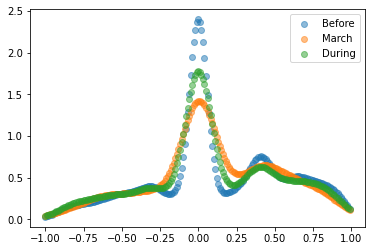

In [24]:
density_before = kde.gaussian_kde(df["compound_sentiment"][df['before']])
density_march = kde.gaussian_kde(df["compound_sentiment"][df['march']])
density_during = kde.gaussian_kde(df["compound_sentiment"][df['during']])
x = np.arange(-1.0, 1.0, 0.01)
plt.scatter(x, density_before(x), alpha=0.5, label="Before")
plt.scatter(x, density_march(x), alpha=0.5, label="March")
plt.scatter(x, density_during(x), alpha=0.5, label="During")
plt.legend(loc="upper right")
plt.show()

Scatter plot comparing daily average before and during the pandemic

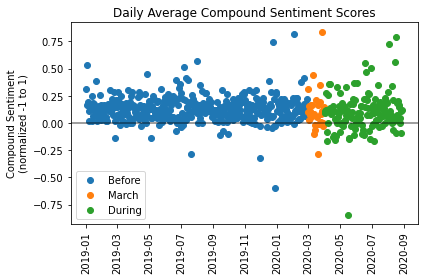

In [25]:
df['day'] = pd.to_datetime(df['date_created'], format="%Y-%m-%d")
daily_ave = df.resample('d', on='day').mean().dropna(how='all')
daily_ave['before'] = daily_ave.index <= pd.Timestamp(2020,2,28)
daily_ave['during'] = daily_ave.index >= pd.Timestamp(2020,4,1)
daily_ave['march'] = ~daily_ave['before'] & ~daily_ave['during']
plt.scatter(daily_ave.index[daily_ave['before']], daily_ave['compound_sentiment'][daily_ave['before']], label="Before")
plt.scatter(daily_ave.index[daily_ave['march']], daily_ave['compound_sentiment'][daily_ave['march']], label="March")
plt.scatter(daily_ave.index[daily_ave['during']], daily_ave['compound_sentiment'][daily_ave['during']], label="During")
plt.legend(loc="lower left")
plt.xticks(rotation=90)
plt.ylabel('Compound Sentiment\n(normalized -1 to 1)')
plt.title('Daily Average Compound Sentiment Scores')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.tight_layout()
plt.savefig('../plots/daily_ave_compound_sentiment.png')

plt.show()

Sentiment is more negative and less positive during the pandemic

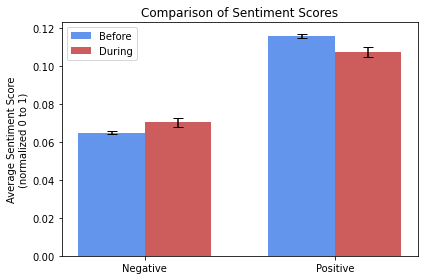

In [26]:
fig, ax = plt.subplots()
width = 0.35
sentiments = ['Negative', 'Positive']
x_pos = np.arange(len(sentiments))

before_mean = [df["neg_sentiment"][df['before']].mean(),
               df["pos_sentiment"][df['before']].mean()]
before_se = [df["neg_sentiment"][df['before']].std()/math.sqrt(len(df["neg_sentiment"][df['before']])),
             df["pos_sentiment"][df['before']].std()/math.sqrt(len(df["pos_sentiment"][df['before']]))]
during_mean = [df["neg_sentiment"][df['during']].mean(),
               df["pos_sentiment"][df['during']].mean()]
during_se = [df["neg_sentiment"][df['during']].std()/math.sqrt(len(df["neg_sentiment"][df['during']])),
             df["pos_sentiment"][df['during']].std()/math.sqrt(len(df["pos_sentiment"][df['during']]))]

rects_before = ax.bar(x_pos - width/2, before_mean, width, yerr=before_se,
                label='Before', capsize=5, color="cornflowerblue")
rects_during = ax.bar(x_pos + width/2, during_mean, width, yerr=during_se,
                label='During', capsize=5, color="indianred")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Sentiment Score\n(normalized 0 to 1)')
ax.set_title('Comparison of Sentiment Scores')
ax.set_xticks(x_pos)
ax.set_xticklabels(sentiments)
ax.legend()
fig.tight_layout()
plt.savefig('../plots/sentiment_neg_pos.png')
plt.show()

## Save Clean Data in New Database

In [27]:
df.to_sql('sentiments', conn, if_exists='replace', index=False)